In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
from scorer import ScorerInfo
from pathlib import Path
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")


In [2]:
calcs = {'auROC': ScorerInfo("prroc_rocauc", "rocauc").make(),
         'auPRC': ScorerInfo("prroc_prauc", "prauc", params={"type": "integral"}).make()}

In [3]:
# model_name, version = 'MYPOP-CHS-GHTS-2', 0
# # model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
# path_to_model = '/home/nikgr/mex_models/shades_one_5/%s' % model_name
# path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
# path_to_preds = path_to_model + '/model/predictions_new_format_%s.tsv'
# path_to_conf = path_to_model + '/config.json'
# model_full_descr = 'LegNet (%s)' % (model_name)

In [4]:

# model_name, version = 'GABPA-CHS-GHTS-1', 0
# # model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
# path_to_model = '/home/nikgr/mex_models_prod/shades_one_run/%s' % model_name
# path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
# path_to_preds = path_to_model + '/model/predictions_new_format_%s.tsv'
# path_to_conf = path_to_model + '/config.json'
# model_full_descr = 'LegNet (%s)' % (model_name)

In [5]:
model_name, version = 'ZNF226-CHS-GHTS-1', 0
path_to_model = '/home/nikgr/mex_models/multitesting_test/%s' % model_name
path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
path_to_preds = path_to_model + '/model' #'/model/predictions_new_format.tsv'
path_to_conf = path_to_model + '/config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [6]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/nikgr/mex_models/multitesting_test/ZNF226-CHS-GHTS-1/config.json
{'stem_ch': 40, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': False, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.0025, 'weight_decay': 0.1, 'model_dir': '/home/nikgr/mex_models/multitesting_test/ZNF226-CHS-GHTS-1', 'train_path': '/home/nikgr/MEX/DATASETS/CHS/Train/ZNF226', 'ref_genome_path': '/home/nikgr/hg38/hg38.fa', 'valid_path': '/home/nikgr/MEX/DATASETS/CHS/Test/ZNF226', 'test_path': '/home/nikgr/MEX/DATASETS/GHTS/Test/ZNF226', 'epoch_num': 10, 'device': 1, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 24, 'training': True, 'negatives': ['random'], 'negatives_test': ['foreigns'], 'pwms_path': '/home/nikgr/MEX/best_20_motif_CHS_GHTS/CHS/ZNF226', 'pwms_freeze': True, 'pwm_loc': 'edge', 'model_type': 'LegNet'}


In [7]:
def get_mod_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    aug = ' & '.join(aug)
    neg = ' & '.join(conf['negatives']) + ' neg.'
    ep_n = f'{conf["epoch_num"]} ep.'
    return f'LegNet ' + ', '.join([aug, neg, ep_n])

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

mod_info = get_mod_info(model_config)
run_info = get_run_info(model_config)
print(mod_info)
print(run_info)

LegNet with rev & 25 shift aug, random neg., 10 ep.
ZNF226 CHS/GHTS


In [8]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss
5,0.032644,0.896845,5,209,0.037076
6,0.032061,0.890800,6,244,0.034736
7,0.031768,0.907295,7,279,0.033238
8,0.030299,0.916608,8,314,0.030957
9,0.030234,0.917125,9,349,0.029897


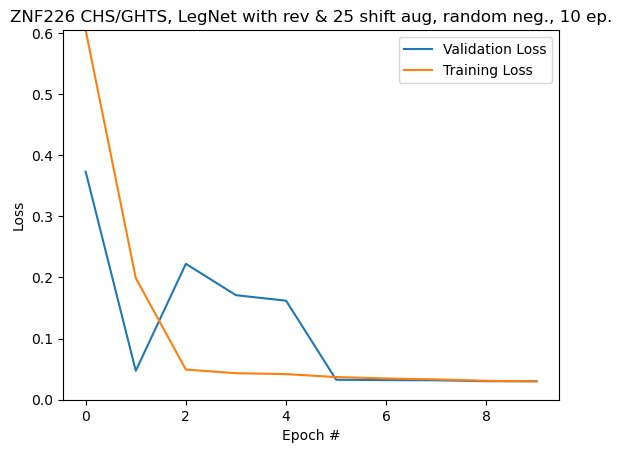

In [9]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


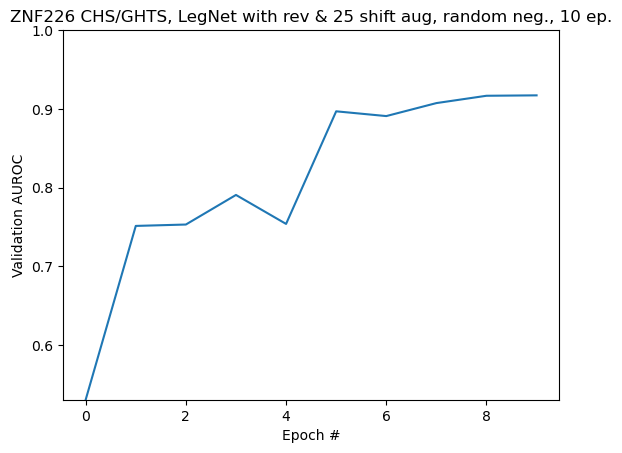

In [10]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
# ax.set_ylim(0.8, 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [11]:
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}
def process_preds_df(path, split, old=False):
    preds_df = pd.read_csv(path % split if not old else path, sep='\t')
    preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
    return preds_df

In [12]:
def process_multitesting_preds_df(path):
    if isinstance(path, str):
        path = Path(path)
    files = path.rglob('*.tsv')
    for file in files:
        if 'predictions' not in file.stem:
            continue
        name_components = file.stem.split('_')
        preds_df = pd.read_csv(file, sep='\t')
        preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
        yield (preds_df, name_components[3], name_components[4])

In [13]:
def plot_roc(preds_df, split, negative=''):
    ax = plt.axes()
    ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.title(f'ROC on {run_info}, {mod_info} [{split} {negative}]')
        
    for pred in preds:
        fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
        auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
        auc_correct = calcs['auROC'].score(preds_df[pred], preds_df['class_'])
        print(pred, auc_correct)

        plt.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
    plt.show()
    
def plot_pr(preds_df, split, negative=''):
    ax = plt.axes()
    # ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.title(f'PR on {run_info}, {mod_info} [{split} {negative}]')
        
    for pred in preds:
        precision, recall, _ = metrics.precision_recall_curve(preds_df['class_'], preds_df[pred])
        pr = metrics.average_precision_score(preds_df['class_'], preds_df[pred])
        pr_correct = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
        print(pred, pr_correct)

        plt.plot(recall, precision, label=f'{preds_names[pred]}, PR = {pr:.3}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower right')
    plt.show()

In [14]:
try:
    for split in ('valid', 'test'):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  
        

----------------------------------------valid-----------------------------------------


In [15]:
try:
    for split in ('test',):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split, old=True)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  

-----------------------------------------test-----------------------------------------


*************cross***************************random*************
forw_pred 0.8560353613586584
avg_pred 0.8779415771764727
rev_pred 0.8569008220011898


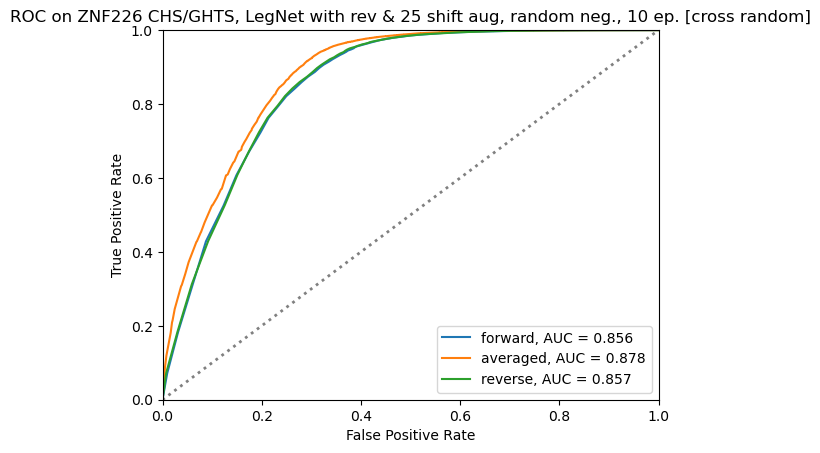

forw_pred 0.9975818807755944
avg_pred 0.998126109768736
rev_pred 0.9976258120544673


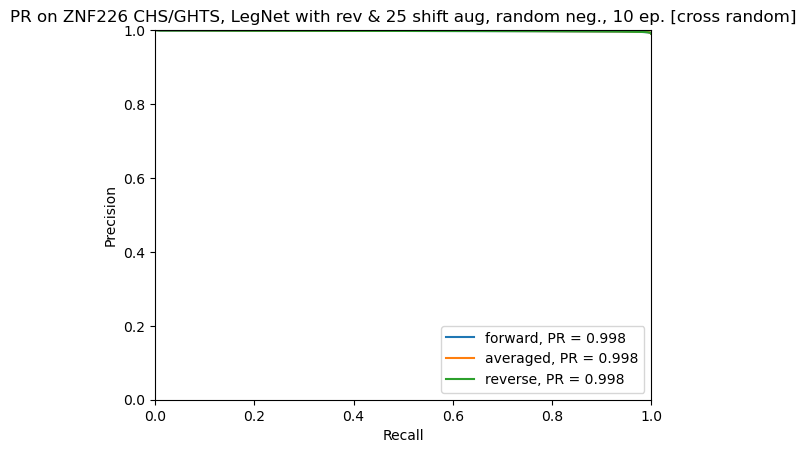

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


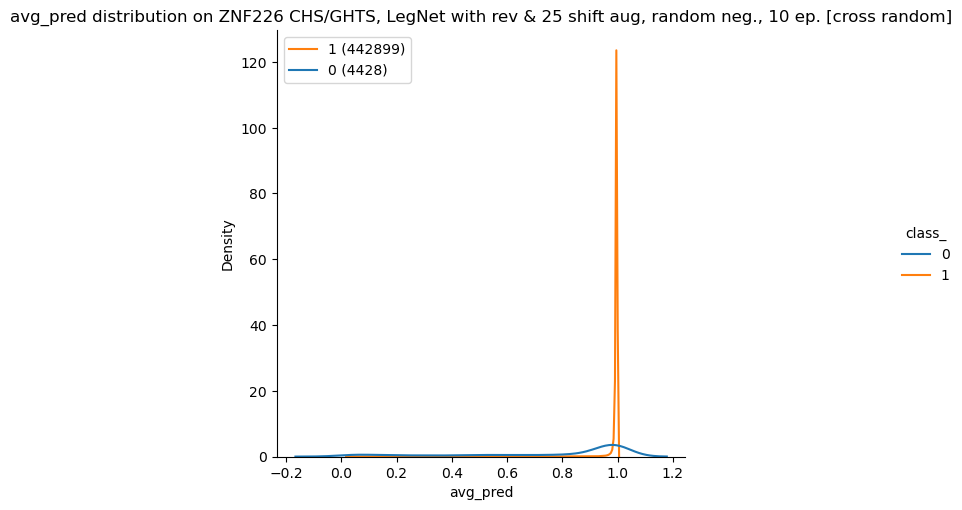


*************inside*************************foreigns************
forw_pred 0.9135603833379243
avg_pred 0.9172029087292444
rev_pred 0.9045937201092605


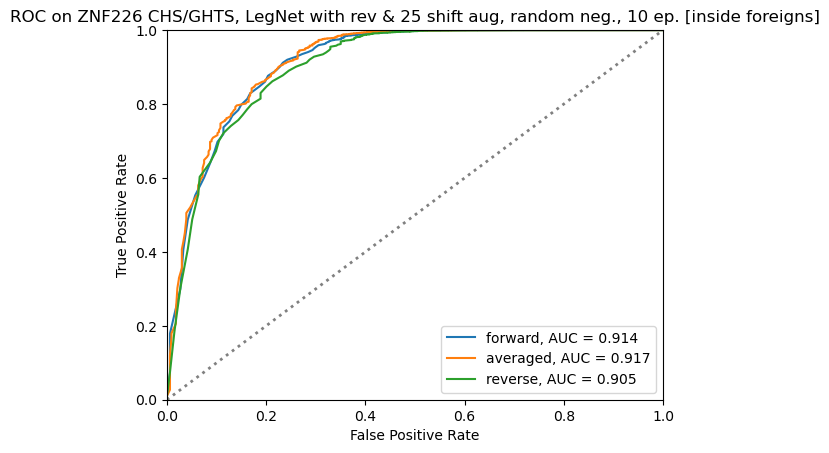

forw_pred 0.9987109543385749
avg_pred 0.9987121916714801
rev_pred 0.998549806003502


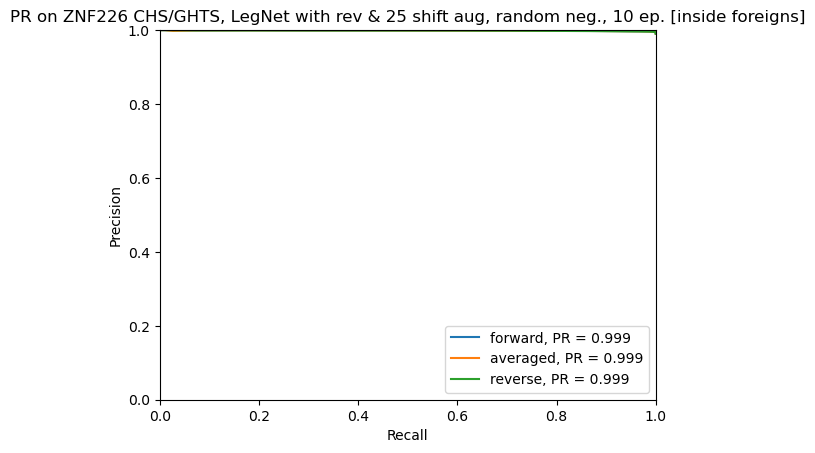

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


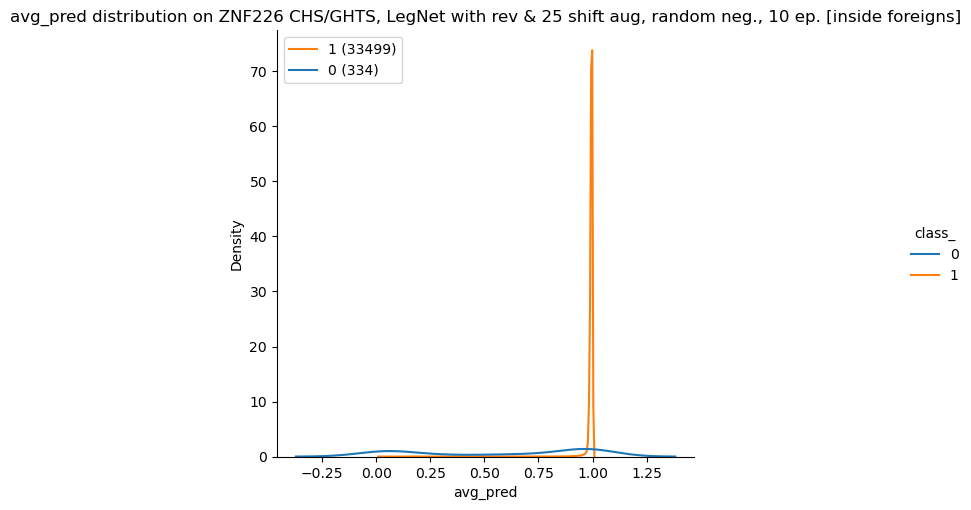


*************inside**************************shades*************
forw_pred 0.9224063084593146
avg_pred 0.9259105108169312
rev_pred 0.913737547326871


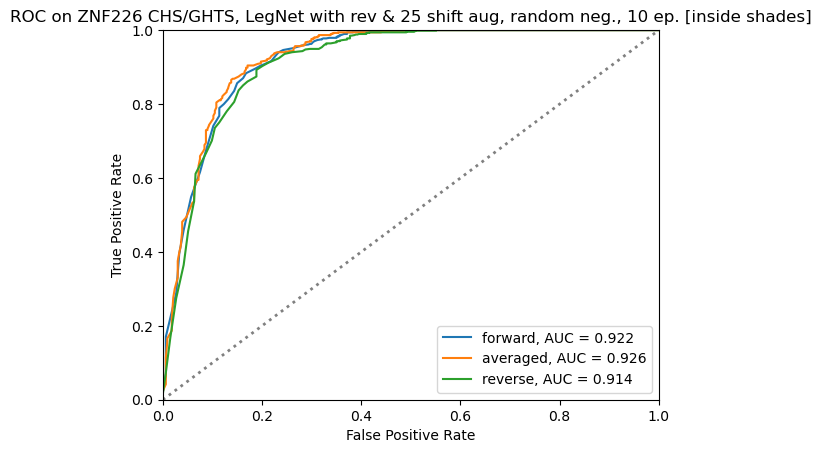

forw_pred 0.9448431650842815
avg_pred 0.9452466092251112
rev_pred 0.9369504219963529


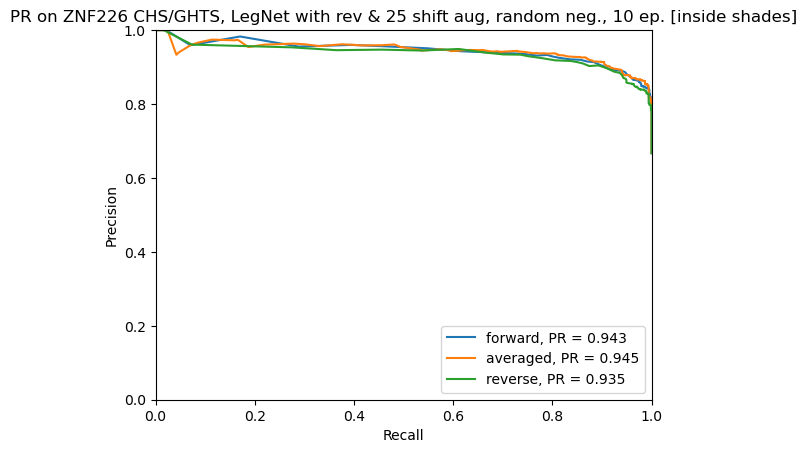

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


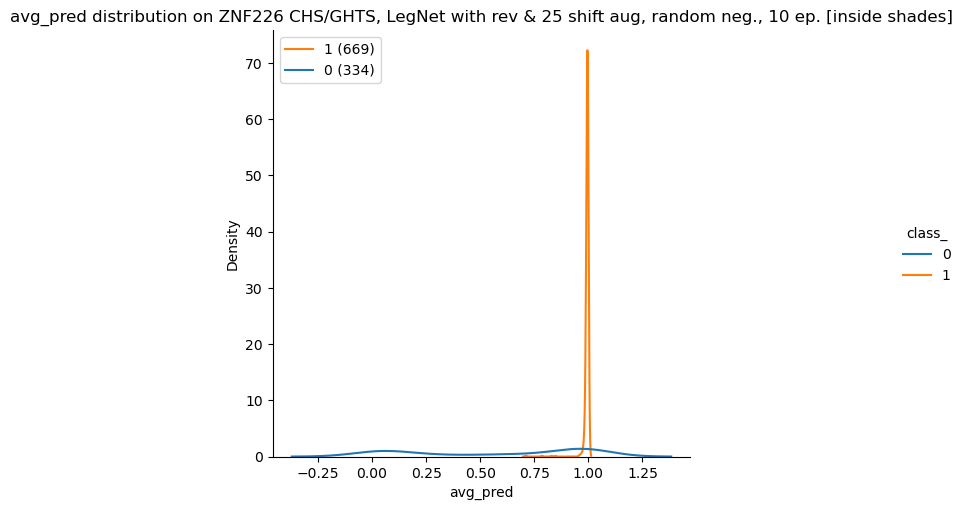


*************cross***************************shades*************
forw_pred 0.8504876710064352
avg_pred 0.8716253770628928
rev_pred 0.8509355985468633


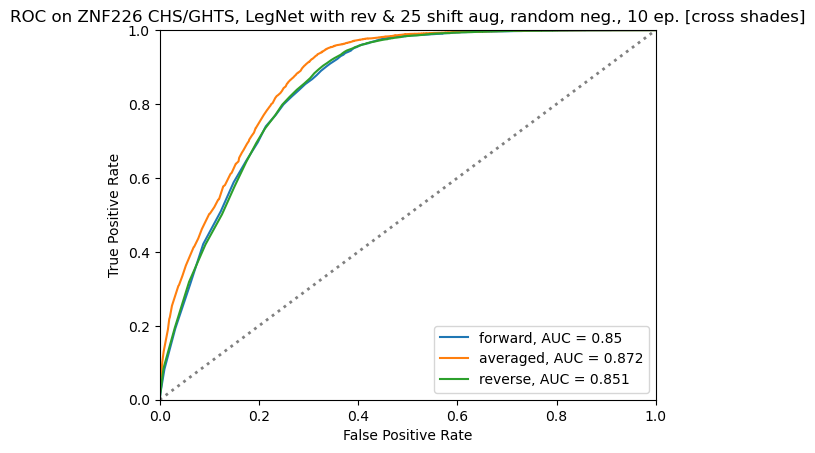

forw_pred 0.8887345108507161
avg_pred 0.9107519821651379
rev_pred 0.8902043455557839


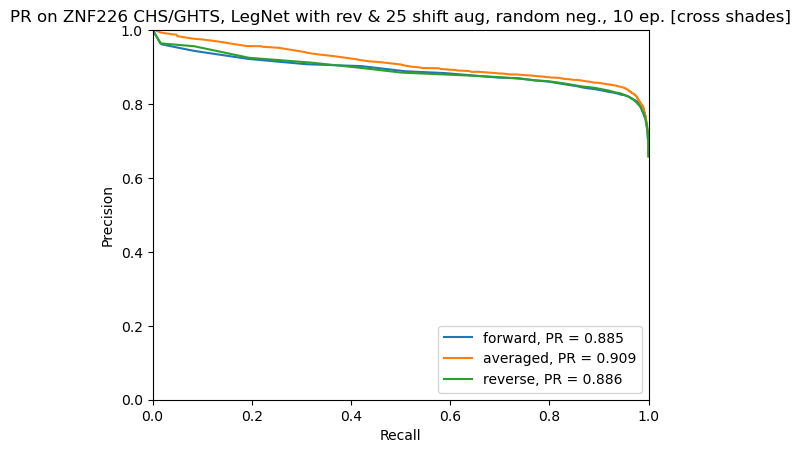

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


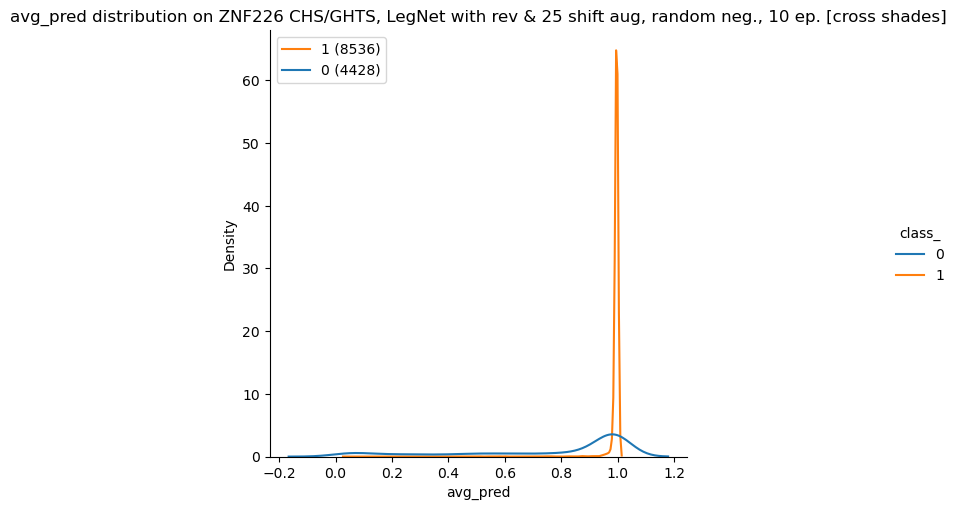


*************inside**************************random*************
forw_pred 0.9170393950449499
avg_pred 0.9210172150996374
rev_pred 0.9090472000862301


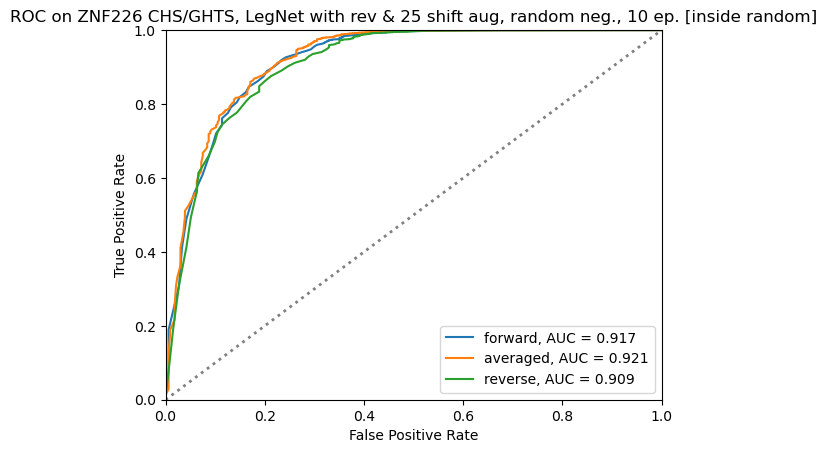

forw_pred 0.9987678925493816
avg_pred 0.9987737201990247
rev_pred 0.9986130030177747


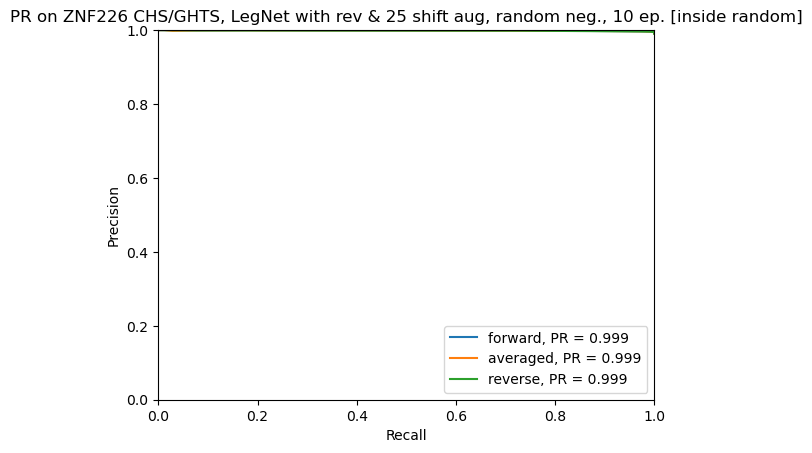

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


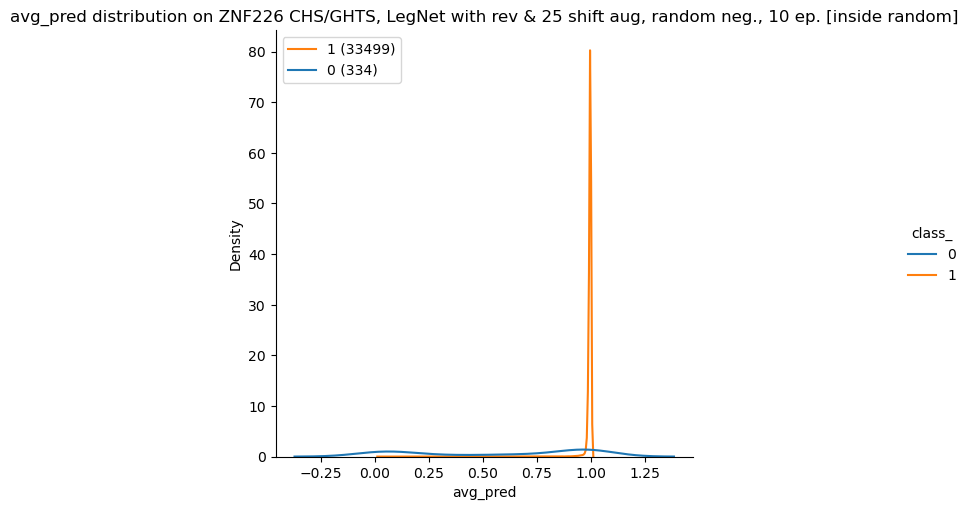


*************cross**************************foreigns************
forw_pred 0.8182022691452634
avg_pred 0.841476530872668
rev_pred 0.8197191606260837


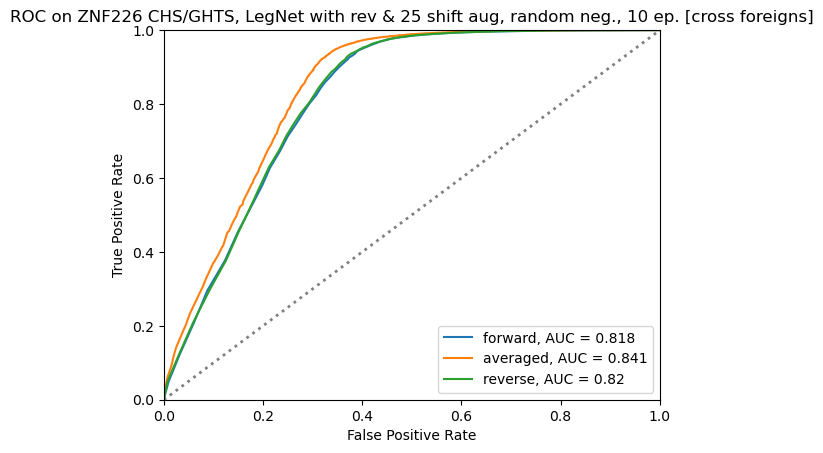

forw_pred 0.9967254771324571
avg_pred 0.99726427660829
rev_pred 0.9967754681032645


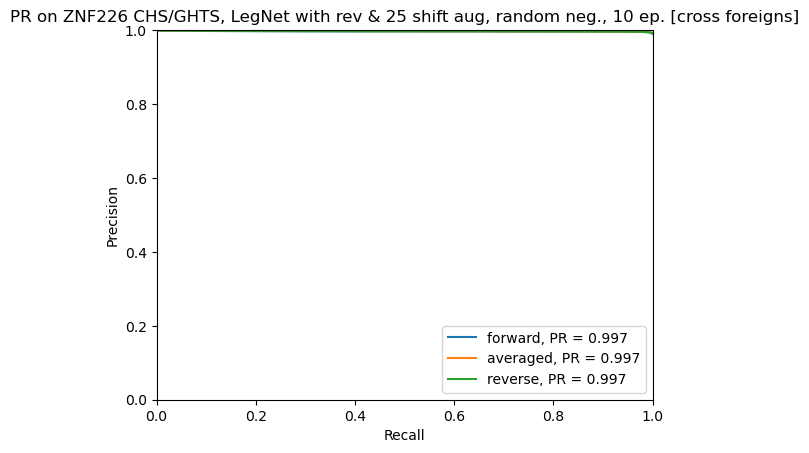

/home/nikgr/miniconda3/envs/banc_seq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


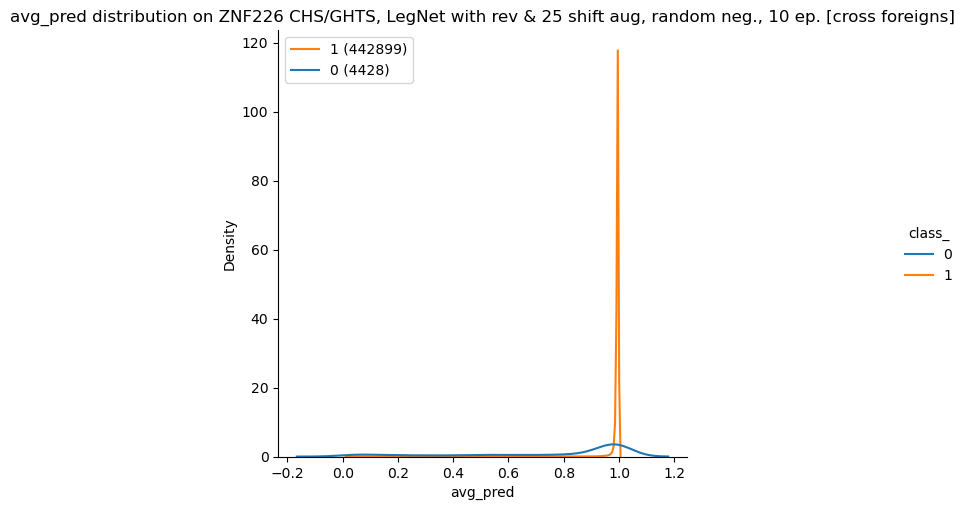

In [18]:
try:
    for preds_df, split, negative in process_multitesting_preds_df(path_to_preds):
        print(f'{split:*^32s}{negative:*^32s}')
        plot_roc(preds_df, split, negative)
        plot_pr(preds_df, split, negative)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split} {negative}]')
        plt.legend(labels = [f'{x} ({n})' for x, n in preds_df['class_'].value_counts().items()])
        plt.show()
        print('')
except Exception as ex:
    raise ex